In [1]:
import importlib
import model.cnn
importlib.reload(model.cnn)
from model.cnn import E2ResNet
print("cnn.py loaded")

cnn.py loaded


In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import e2cnn

mkdir -p failed for path /home/qbaodo/.cache/matplotlib: [Errno 13] Permission denied: '/home/qbaodo/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-4_c1jzna because there was an issue with the default path (/home/qbaodo/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # AddGaussianNoise(std=1.)
])

train_dataset = datasets.MNIST(root='./data', train=True,download=False,transform = transform)

In [7]:

import random
from torch.utils.data import Subset,DataLoader

random.seed(32)
subset_indices = random.sample(range(len(train_dataset)),100)


In [8]:


dataset = Subset(train_dataset, indices= subset_indices)
loader = DataLoader(dataset,batch_size = 50, shuffle=True)


In [31]:
from torchvision.transforms import functional as TF
Y = [dataset[i][0] for i in range(len(dataset))]
Y = torch.stack(Y)

translated_dataset= []
for shift_h in range(28):
    for shift_v in range(28):
        translated_dataset.append(torch.roll(Y,shifts=(shift_h,shift_v),dims=(2,3)))
translated_dataset = torch.stack(translated_dataset).reshape(-1,1,28,28)

rotated_dataset= []
for i in range(8):
    rotated_dataset.append(TF.rotate(Y,angle=i*45))
rotated_dataset = torch.stack(rotated_dataset).reshape(-1,1,28,28)


In [10]:
sigma = 2

In [60]:

def weights_calculation(x_input,dataset):
    b,c,h,w = dataset.shape
    dataset_flat = dataset.reshape(b,c,h*w).squeeze(1)
    x_input_flat = x_input.flatten()
    power = -0.5*torch.linalg.norm(dataset_flat - x_input_flat,dim=1)**2/sigma**2
    weights_vec = torch.softmax(power,dim=0)
    return weights_vec


In [12]:
def show_images(tensor):
    tensor = tensor.detach().cpu().permute(0,2,3,1)
    num_images = tensor.size(0)
    cols = num_images
    rows = 1
    
    plt.figure(figsize=(2 * num_images, 2))
    for i, img in enumerate(tensor):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)  # Remove `cmap='gray'` for RGB images
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

In [ ]:
import torch.nn.functional as F
import math

def rotate_preserve(image, angle_deg):
    """
    Rotate an image with circular padding and crop back to original size.
    
    Args:
        image: (C, H, W) torch.Tensor
        angle_deg: float, rotation angle in degrees

    Returns:
        Rotated image of shape (C, H, W)
    """
    C, H, W = image.shape
    angle_rad = math.radians(angle_deg)

    # Step 1: Circular pad (pad half the height/width)
    pad_h = H // 2
    pad_w = W // 2
    image_padded = F.pad(image, pad=[pad_w, pad_w, pad_h, pad_h], mode='circular')  # (C, H+2*pad, W+2*pad)

    H_pad, W_pad = image_padded.shape[1], image_padded.shape[2]

    # Step 2: Rotate with grid_sample
    theta = torch.tensor([
        [math.cos(angle_rad), -math.sin(angle_rad), 0],
        [math.sin(angle_rad),  math.cos(angle_rad), 0]
    ], dtype=torch.float).unsqueeze(0)

    grid = F.affine_grid(theta, size=(1, C, H_pad, W_pad), align_corners=False)
    image_padded = image_padded.unsqueeze(0)  # Add batch dim

    rotated = F.grid_sample(image_padded, grid, mode='bilinear', padding_mode='zeros', align_corners=False)
    rotated = rotated.squeeze(0)

    # Step 3: Center crop back to original size
    start_h = (H_pad - H) // 2
    start_w = (W_pad - W) // 2
    cropped = rotated[:, start_h:start_h + H, start_w:start_w + W]

    return cropped

def biggest_disk_mask(h: int = 28, w: int = 28, *, device=None) -> torch.Tensor:
    """
    Returns a (1, 1, h, w) boolean tensor that is True inside the
    maximal inscribed circle and False elsewhere.
    """
    # coordinate grid
    y = torch.arange(h, device=device).view(-1, 1).float()
    x = torch.arange(w, device=device).view(1, -1).float()

    # circle parameters
    cy, cx = (h - 1) / 2.0, (w - 1) / 2.0        # geometric centre
    r2 = (min(h, w) / 2.0) ** 2                  # radius²

    mask2d = (x - cx) ** 2 + (y - cy) ** 2 <= r2  # (h, w)
    return mask2d.unsqueeze(0).unsqueeze(0)       # (1, 1, h, w)


In [109]:
from torch.optim.lr_scheduler import LinearLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
E2RN_model = E2ResNet(input_size=(28,28),type_out_list=[16,32,128,128,32,16])
optimizer = torch.optim.Adam(E2RN_model.parameters(),lr = 0.005)
scheduler = LinearLR(optimizer,0.6,1.,50)
loss_fn = torch.nn.MSELoss(reduction='mean')

print(sum( p.numel() for p in E2RN_model.parameters()))

TypeError: 'Tensor' object is not callable

In [14]:
with torch.no_grad():
    # E2RN_model.reset_parameters()
    weight_norm = [torch.linalg.norm(p.ravel()).item() for p in E2RN_model.parameters()]
    # grad_norm = [torch.linalg.norm(p.grad.ravel()).item() for p in model.parameters() if p.requires_grad]
    grad_norm = [p.grad for p in E2RN_model.parameters() if p.requires_grad]

    print(weight_norm)
    print(grad_norm)

[0.0, 3.240615129470825, 0.0, 2.8286666870117188, 2.8284270763397217, 0.0, 2.8284270763397217, 0.0, 2.8343911170959473, 1.8535528182983398, 0.0, 4.07725191116333, 0.0, 3.981764554977417, 4.0, 0.0, 4.0, 0.0, 5.705113410949707, 0.8589754700660706, 0.0, 8.185456275939941, 0.0, 8.02676773071289, 8.0, 0.0, 8.0, 0.0, 11.728533744812012, 1.1204661130905151, 0.0, 7.994370460510254, 0.0, 7.968396186828613, 8.0, 0.0, 8.0, 0.0, 11.198840141296387, 0.619610607624054, 0.0, 3.9713988304138184, 0.0, 3.9317400455474854, 4.0, 0.0, 4.0, 0.0, 5.749039649963379, 0.29212716221809387, 0.0, 2.7261769771575928, 0.0, 2.883774757385254, 2.8284270763397217, 0.0, 2.8284270763397217, 0.0, 4.215353488922119, 0.4888244867324829, 0.0, 0.940706729888916, 0.0, 1.032110571861267, 1.0, 0.0, 1.0, 0.0, 0.9632685780525208, 0.20814014971256256]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

In [108]:
for name, p in E2RN_model.named_parameters():
    print(name, p.shape, p)
    print('---------------------------------')
    print(p.numel())

layers.0.conv1.bias torch.Size([16]) Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
---------------------------------
16
layers.0.conv1.weights torch.Size([32]) Parameter containing:
tensor([-0.3417, -0.6105, -1.6005, -0.2660, -0.7433, -2.0793, -0.1070,  0.0079,
         0.1619, -1.3175, -0.1582,  0.7854, -0.1001, -0.5701,  1.0888, -0.4907,
        -0.5038,  1.0625, -0.7010, -0.8338,  0.3158, -1.1506, -1.2039,  0.4143,
        -0.4718, -0.7719, -0.7533,  0.2904,  0.1297, -0.7674, -0.9433, -0.6800],
       requires_grad=True)
---------------------------------
32
layers.0.conv2.bias torch.Size([16]) Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
---------------------------------
16
layers.0.conv2.weights torch.Size([512]) Parameter containing:
tensor([ 2.4406e-02, -4.3380e-02,  1.8746e-01,  1.9562e-01,  1.4120e-01,
        -2.4244e-01,  9.1

In [110]:
from tqdm import tqdm

def train(model,dataloader,optimizer,loss_fn,epochs = 101):
    print("Training starts")
    model.to(device)

    pb_bar = tqdm(range(epochs))
    for epoch in pb_bar:
        model.train()
        running_loss = 0.0
        for X, _ in dataloader:
            X = X.to(device) 
            Y = X + sigma * torch.randn_like(X)
            Y = e2cnn.nn.GeometricTensor(Y,model.feat_type_in_list[0])

            optimizer.zero_grad(set_to_none=True)
            outputs = model(Y).tensor 

            loss = loss_fn(outputs, X)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # with torch.no_grad():
            #     weight_norm = [torch.linalg.norm(p.ravel()).item() for p in model.parameters()]
            #     # grad_norm = [torch.linalg.norm(p.grad.ravel()).item() for p in model.parameters() if p.requires_grad]
            #     grad_norm = [p.grad for p in model.parameters() if p.requires_grad]

            #     print(weight_norm)
            #     print(grad_norm)

        avg_loss = running_loss/len(dataloader)
        last_lr = scheduler.get_last_lr()[0]
        pb_bar.set_description(f'Avg loss = {avg_loss:.3e}, lr = {last_lr:.3f}')
        
        scheduler.step()
        with torch.no_grad():
            if epoch%100==0:
                # print(f"Epoch {epoch} Loss : {avg_loss:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}")
                show_images(X[:4])
                show_images(Y.tensor[:4])
                show_images(outputs[:4])

def predict(model,input_tensor):
    device = next(model.parameters()).device
    model.eval()
    input = e2cnn.nn.GeometricTensor(input_tensor.clone(),model.feat_type_in_list[0])
    with torch.no_grad():
        input = input.to(device)
        output = model(input)
    return output.tensor.cpu()


In [111]:
x, _ = next(iter(loader))
x = x.to(device)
y = x + sigma * torch.randn_like(x)
E2RN_model = E2RN_model.to(device)

y =  e2cnn.nn.GeometricTensor(y, E2RN_model.feat_type_in_list[0])
with torch.no_grad():
    outputs = y
    for submodel in E2RN_model.layers:
        outputs = submodel(outputs)
        print(outputs.tensor)
# print(outputs)
# loss = loss_fn(outputs, x)
# print(loss)




tensor([[[[-1.9245e+00,  8.4951e+00, -3.0919e+00,  ...,  4.3081e+00,
           -1.0426e+01,  1.1201e+01],
          [-4.0973e+00, -1.5126e+00, -4.3158e-01,  ...,  1.0929e+00,
           -1.5522e+00, -1.5680e+01],
          [ 1.0370e+01, -1.3380e+00,  2.3565e+00,  ..., -1.0869e+01,
           -1.5206e+00,  1.1321e+01],
          ...,
          [-7.8670e+00,  2.3319e+00,  7.1248e+00,  ...,  6.4758e-01,
            1.1100e+01, -8.3759e+00],
          [-1.6079e-01, -5.5347e+00, -1.4345e+00,  ..., -7.8091e-01,
           -6.3730e+00,  9.8267e+00],
          [-6.4796e-01,  8.0889e+00, -5.4560e-02,  ..., -3.5982e+00,
            2.9610e+00, -6.5768e+00]],

         [[-1.5375e+00,  6.8868e+00, -2.9374e+00,  ...,  2.0161e-01,
           -1.0665e+01,  3.6835e+00],
          [-3.0055e+00, -9.8146e-01, -3.3659e-01,  ..., -3.2578e+00,
           -4.9896e+00, -1.3245e+01],
          [ 9.0729e+00, -7.2955e-01,  2.2843e+00,  ..., -1.1253e+01,
           -3.0461e+00,  8.3113e+00],
          ...,
     

Training starts


  0%|          | 0/1000 [00:00<?, ?it/s]

Avg loss = 1.275e+03, lr = 0.003:   0%|          | 0/1000 [00:00<?, ?it/s]

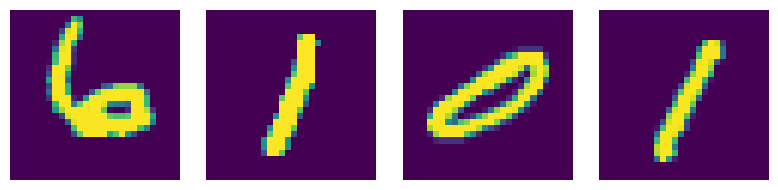

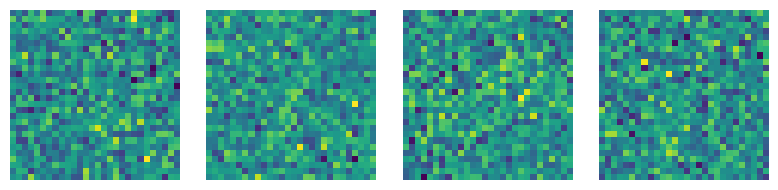

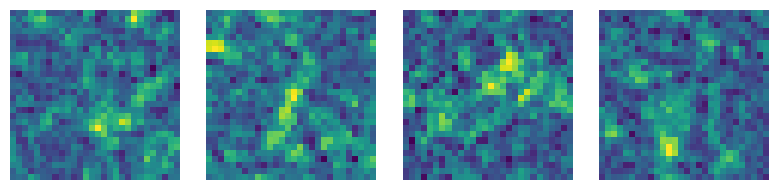

Avg loss = 9.059e-02, lr = 0.005:  10%|█         | 100/1000 [00:33<04:49,  3.11it/s]

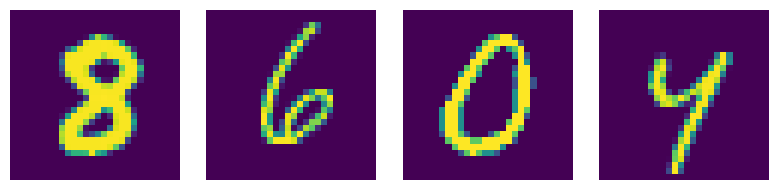

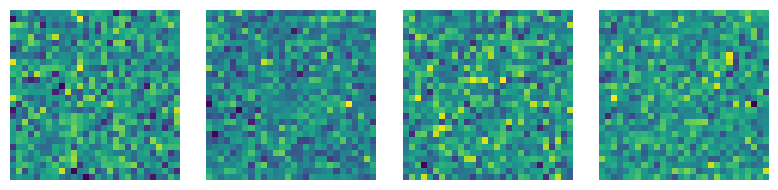

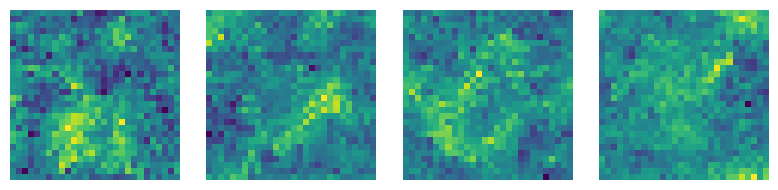

Avg loss = 8.131e-02, lr = 0.005:  20%|██        | 200/1000 [01:05<04:17,  3.11it/s]

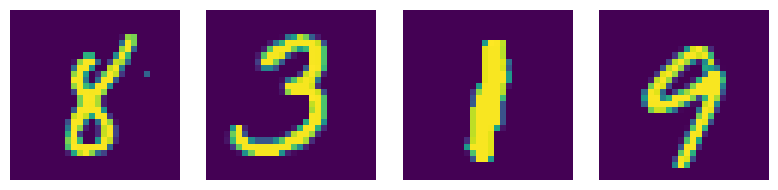

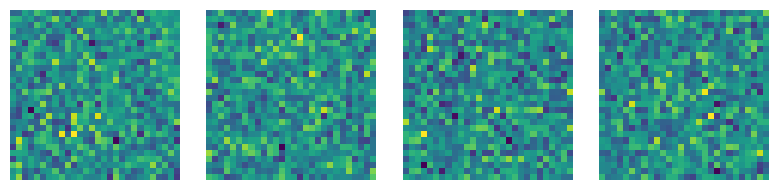

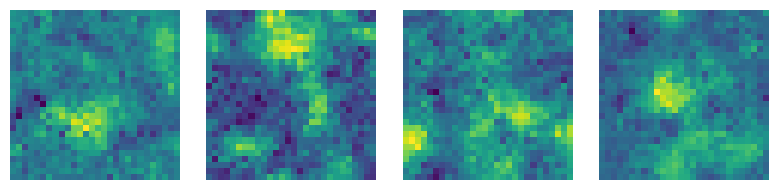

Avg loss = 7.628e-02, lr = 0.005:  30%|███       | 300/1000 [01:38<03:45,  3.10it/s]

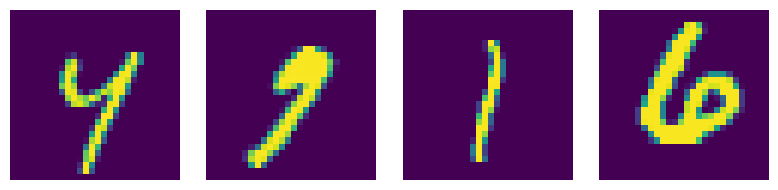

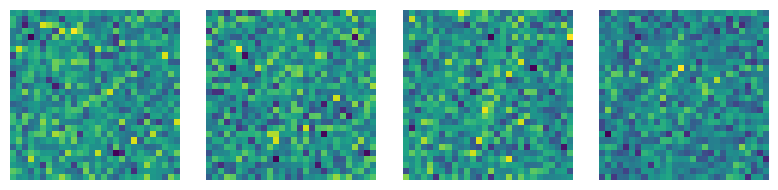

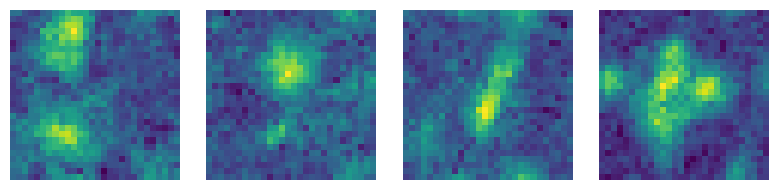

Avg loss = 7.423e-02, lr = 0.005:  40%|████      | 400/1000 [02:11<03:24,  2.94it/s]

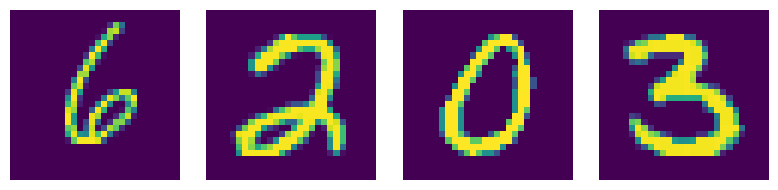

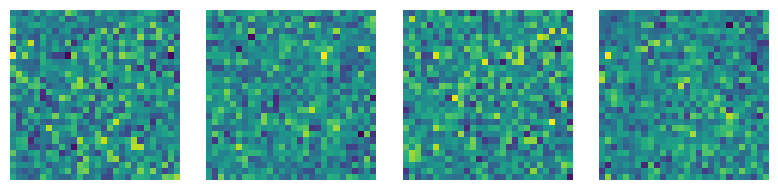

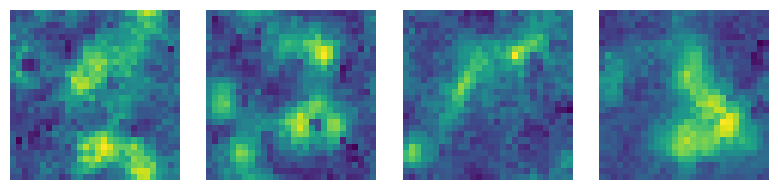

Avg loss = 7.155e-02, lr = 0.005:  50%|█████     | 500/1000 [02:45<02:43,  3.06it/s]

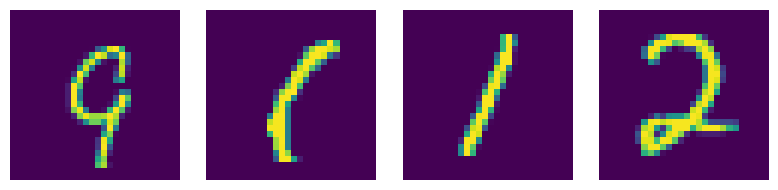

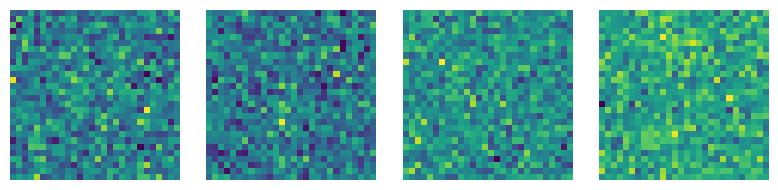

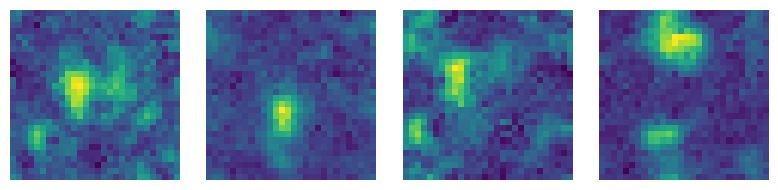

Avg loss = 7.006e-02, lr = 0.005:  60%|██████    | 600/1000 [03:18<02:11,  3.04it/s]

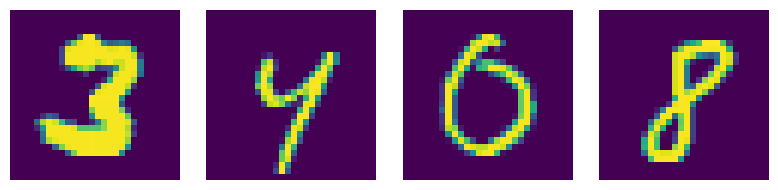

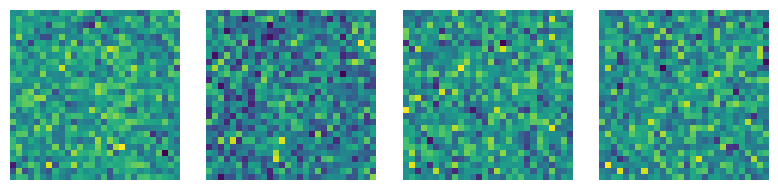

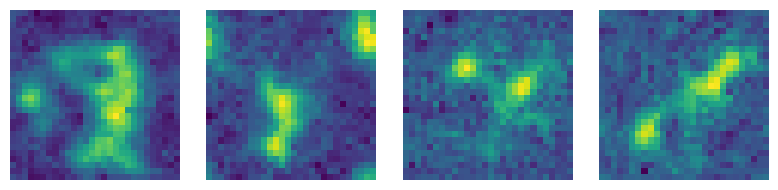

Avg loss = 7.151e-02, lr = 0.005:  70%|███████   | 700/1000 [03:52<01:37,  3.07it/s]

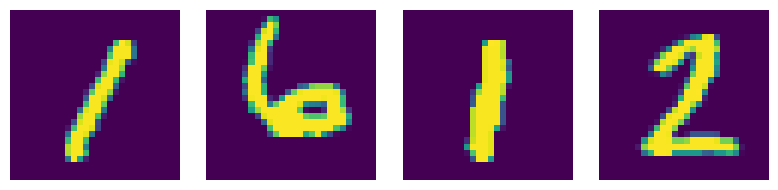

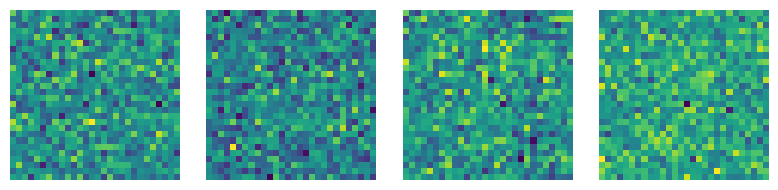

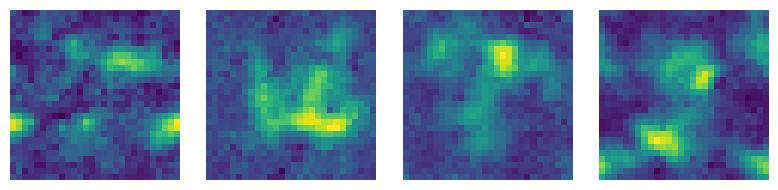

Avg loss = 7.278e-02, lr = 0.005:  80%|████████  | 800/1000 [04:25<01:06,  3.00it/s]

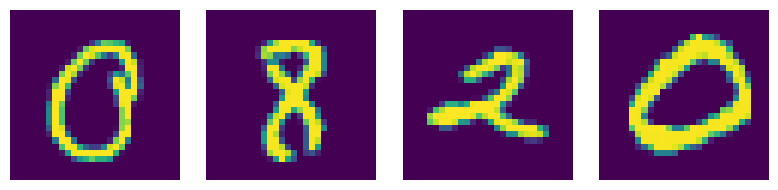

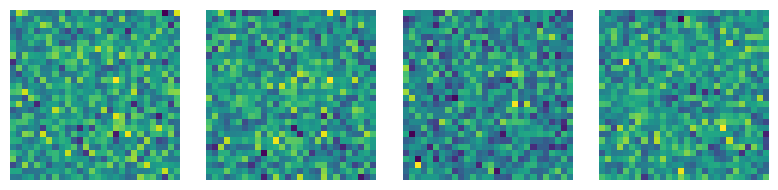

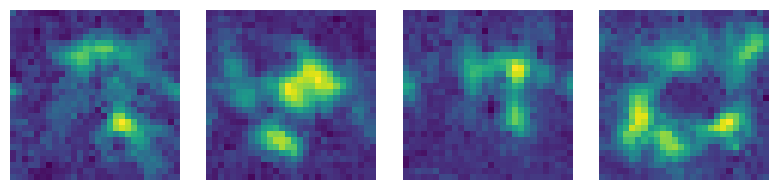

Avg loss = 7.311e-02, lr = 0.005:  90%|█████████ | 900/1000 [04:58<00:32,  3.04it/s]

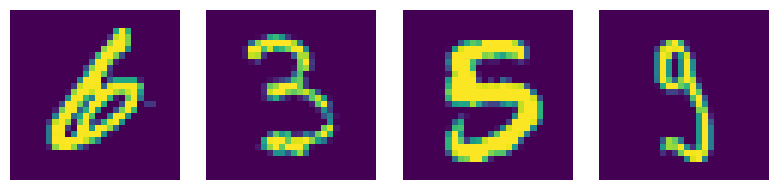

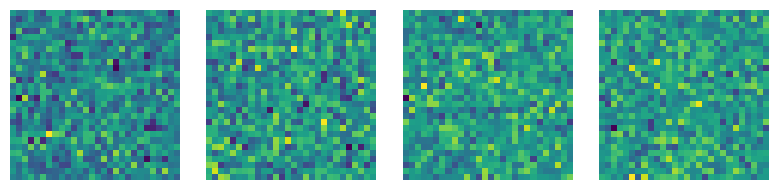

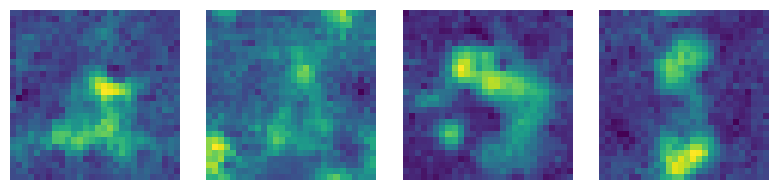

Avg loss = 7.097e-02, lr = 0.005: 100%|██████████| 1000/1000 [05:31<00:00,  3.01it/s]


In [112]:
train(E2RN_model, loader, optimizer, loss_fn, epochs=1000)


tensor(5.3759e-05)


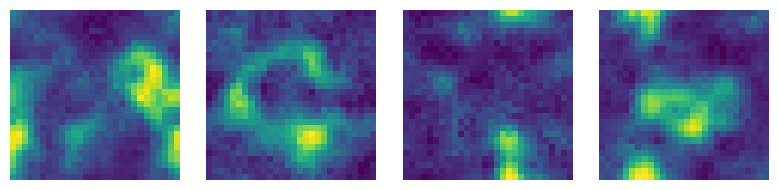

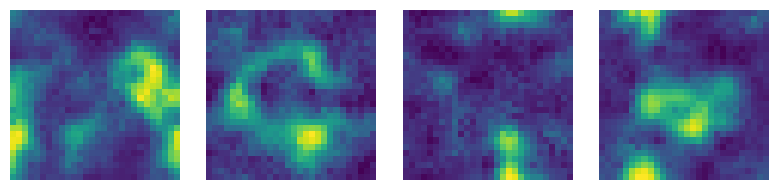

In [ ]:
# -------------------Translation equivariance test--------------------
N = 50
trans = torch.randint(low=0,high=28,size=(N,2))
idx = torch.randint(low = 0, high= 100,size=(N,))
input = torch.stack([dataset[i][0] for i in idx])
# input = torch.randn(100,1,28,28)

input = input + sigma*torch.randn_like(input)
output = predict(E2RN_model,input)
trans_output = torch.stack([torch.roll(output[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
trans_input =torch.stack([torch.roll(input[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
output_trans = predict(E2RN_model,trans_input)

diff = torch.mean(torch.linalg.norm((trans_output-output_trans).reshape(50,28*28),dim=1))
print(diff)
show_images(trans_output[:4])
show_images(output_trans[:4])

In [35]:
disk_mask = biggest_disk_mask()

tensor(1.4126)


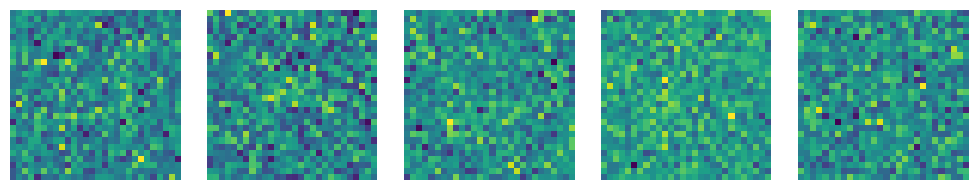

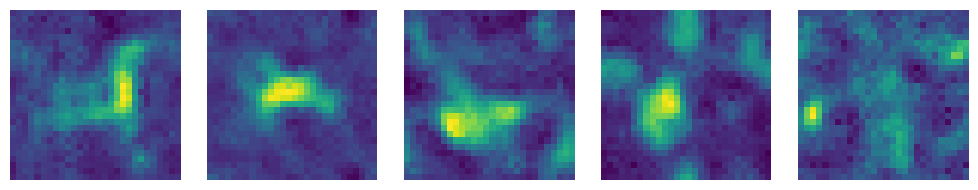

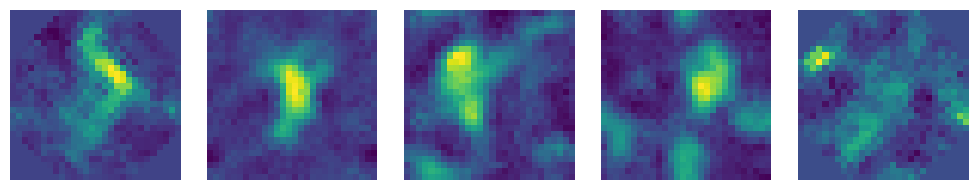

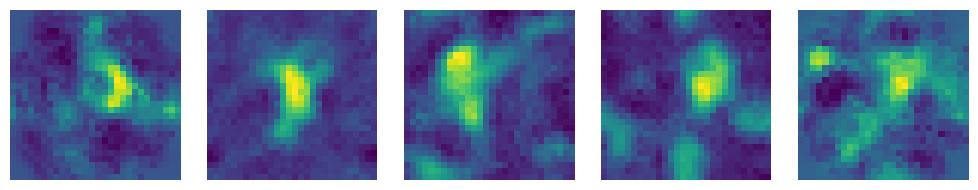

In [68]:
# --------------------Rotation equivariance test----------------------
N = 50
rotate = torch.randint(0,8,size=(N,))*45
idx = torch.randint(low = 0, high= 100,size=(N,))
input = torch.stack([dataset[i][0] for i in idx])
# input = torch.randn(100,1,28,28)

input = input + sigma*torch.randn_like(input)
output = predict(E2RN_model,input)
rotated_output = torch.stack([TF.rotate(output[i],angle=float(rotate[i])) for i in range(N)])
rotated_input =torch.stack([TF.rotate(input[i],angle=float(rotate[i])) for i in range(N)])
# rotated_output = torch.stack([rotate_preserve(output[i],float(rotate[i])) for i in range(N)])
# rotated_input =torch.stack([rotate_preserve(input[i],float(rotate[i])) for i in range(N)])
output_rotated = predict(E2RN_model,rotated_input)

diff = torch.mean(torch.linalg.norm((disk_mask*(rotated_output-output_rotated)).reshape(N,28*28),dim=1))
print(diff)

show_images(input[:5])
show_images(output[:5])
show_images(rotated_output[:5])
show_images(output_rotated[:5])


tensor(1.2438)


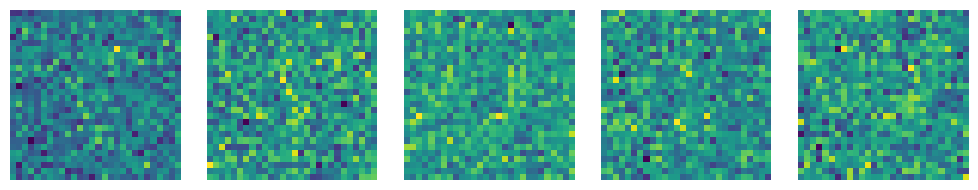

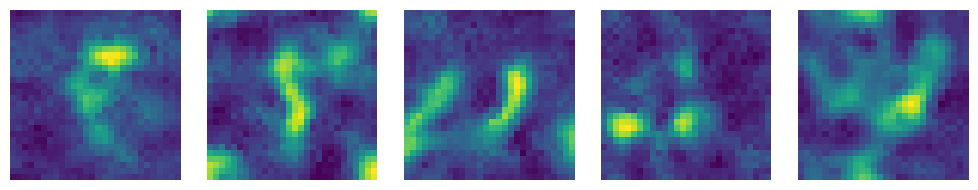

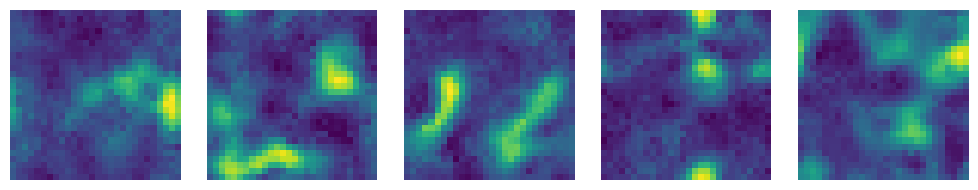

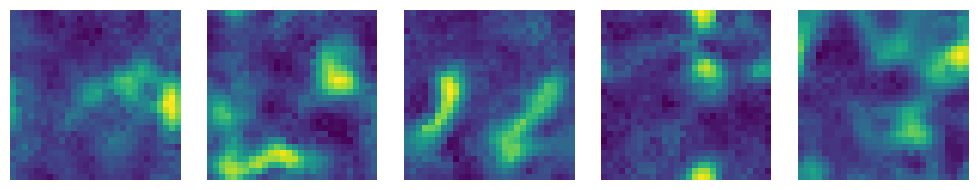

In [69]:
# --------------------Rotation and translation equivariance test----------------------
N = 50
rotate = torch.randint(0,8,size=(N,))*45
trans = torch.randint(low=0,high=28,size=(N,2))
idx = torch.randint(low = 0, high= 100,size=(N,))
input = torch.stack([dataset[i][0] for i in idx])
# input = torch.randn(100,1,28,28)

input = input + sigma*torch.randn_like(input)
output = predict(E2RN_model,input)
rotated_translated_output = torch.stack([TF.rotate(torch.roll(output[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)),
                                        angle=float(rotate[i])) for i in range(N)])
rotated_translated_input =torch.stack([TF.rotate(torch.roll(input[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)),
                                      angle=float(rotate[i])) for i in range(N)])
# rotated_translated_output = torch.stack([rotate_preserve(output[i],float(rotate[i])) for i in range(N)])
# rotated_translated_input =torch.stack([rotate_preserve(input[i],float(rotate[i])) for i in range(N)])
output_rotated_translated = predict(E2RN_model,rotated_translated_input)

diff = torch.mean(torch.linalg.norm((disk_mask*(rotated_translated_output-output_rotated_translated)).reshape(N,28*28),dim=1))
print(diff)

show_images(input[:5])
show_images(output[:5])
show_images(rotated_translated_output[:5])
show_images(output_rotated_translated[:5])


**Comment:** Our Resnet is equivariance by translation and rotation

In [70]:
# torch.save(E2RN_model.state_dict(), 'ResNet_conv2d.pt')

In [49]:
# E2RN_model.load_state_dict(torch.load('ResNet_conv2d.pt'))

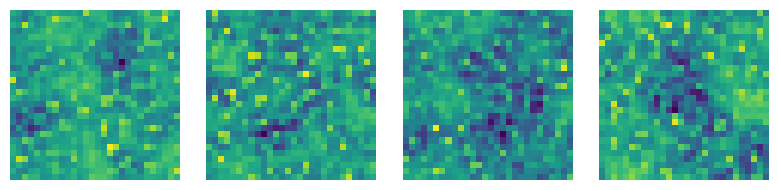

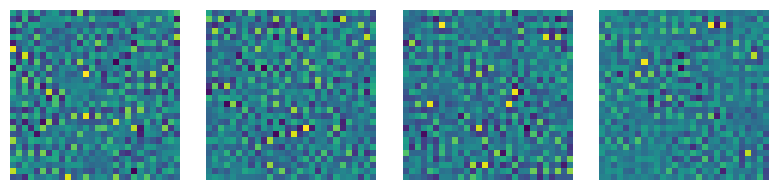

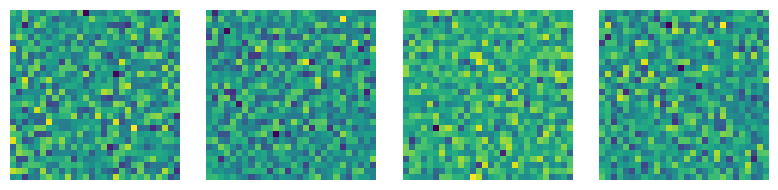

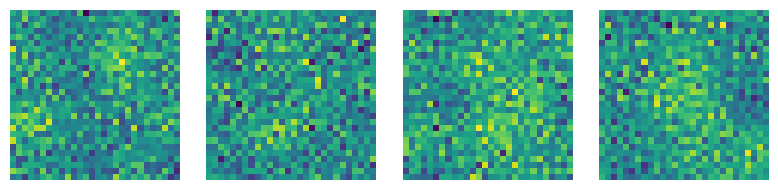

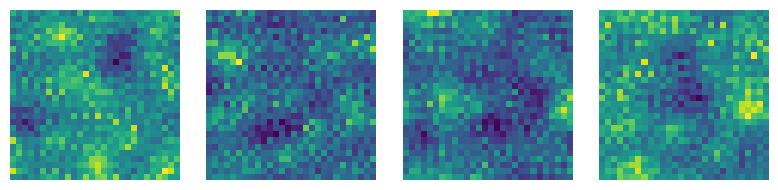

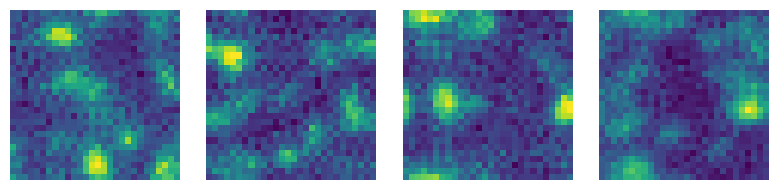

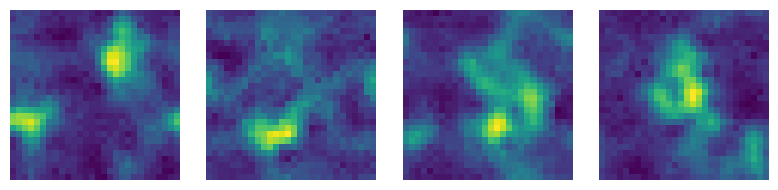

In [101]:
out = Y.clone()[:4]
out = e2cnn.nn.GeometricTensor(out+sigma*torch.randn_like(out),E2RN_model.feat_type_in_list[0]).to(device)
E2RN_model.eval()
with torch.no_grad():
    for submodel in E2RN_model.layers:
        out = submodel(out)
        show_images(out.tensor[:4, 0:1])

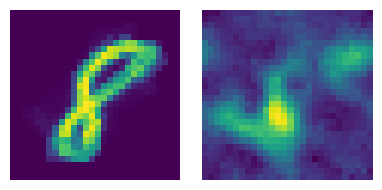

In [100]:
# -----------------Analytique solution rotation equivariance case---------------------
im_test = Y[torch.randint(0,100,(1,))]
im_test = im_test+ sigma*torch.randn_like(im_test)
# im_test = im_test.squeeze(1)
im_generated = predict(E2RN_model,im_test)
weights_rot = weights_calculation(x_input=im_test,dataset=rotated_dataset)
weights_rot = weights_rot[:,None,None,None]

sum = 0
for i in range(rotated_dataset.size(0)//100):
    sum += torch.sum((rotated_dataset[i*100:(i+1)*100]*weights_rot[i*100:(i+1)*100]),dim=0,keepdim=True)

image_predicted_analytic = sum
show_images(torch.stack([image_predicted_analytic,im_generated]).squeeze(1))
